In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import ChiantiPy.core as ch
import scipy.integrate as sint
import scipy.interpolate as si

 ChiantiPy version 0.15.2 
 using cli
 using CLI for selections


/Users/brandt/gitRepos/XRayCrossSections/.venv/lib/python3.11/site-packages/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")


In [2]:
cs = 3E10
sigmaT = 5.67051E-5
kb = 1.380649E-16
mp = 1.672621911E-24 #g

planckev = 4.135667696E-15
cang = 3E18 #Angstroms/s

writeFiles = False

elements = ['h', 'he',  'c', 'o', 'n', 'ne', 'si', 'mg', 's', 'fe', 'na', 'al', 'ar', 'ca', 'ni']
Zelements =[1, 2, 6, 8, 7, 10, 14, 12, 16, 26, 11, 13, 18, 20, 28]

In [3]:
#Verner cross section function
#This is the interpolation function from Verner+1995
def func(E, n, l, params):
    #Params contains [Eth, E0, sigma0, yw, ya, P]
    Eth = params[0]; E0 = params[1]; sigma0 = params[2]
    ya = params[3]; P = params[4]; yw = params[5];
    Q = 5.5 + l - 0.5*P
    y = E/E0
    Fy = ((y - 1.)*(y-1.) + yw*yw)*y**(-Q)*(1. + np.sqrt(y/ya))**(-P)
    sig = sigma0*Fy
    sig[np.where(E < Eth)] = 0.
    return sig

#Klein-Nishina cross section from Longair+2011
def KNcross(E):
    emass = 510998.9461 #ev/c^2
    x = E/emass
    re = 2.8179403227E-13 #cm
    fac1 = 1.0/x
    fac2 = 1. - (2.*(x+1.))/(x*x)
    fac3 = np.log(2*x + 1.)
    fac4 = 4.0/x
    fac5 = 1.0/(2.0*(2.*x+1.)**2)
    facT = fac1*(fac2*fac3 + 0.5 + fac4 - fac5)
    return (np.pi*re**2*facT)*1E18

#Load in cross section data and creation dictionary
#fit parameters taken from Verner+1995. 
crossDat = np.loadtxt('verner1995.tsv', comments='#')
fitDict = {}
for (i, row) in enumerate(crossDat):
    Z = int(row[0])
    Nele = int(row[1])
    n = int(row[2])
    l = int(row[3])
    ID = (Z,Nele,n,l)
    fitParms = row[4:]
    fitDict[ID] = fitParms

In [4]:
#Set temperature array
temp = np.logspace(3.5, 7.5, 128)
#Use ChiantiPy to compute the thermal ionization equilibrum
equilsDict = {}
for el in elements:
    ieq = ch.ioneq(el)
    tmp = ieq.calculate(temp)
    equils = ieq.Ioneq
    equilsDict[el] = equils

In [5]:
Ntemp = 24
Txsec = np.logspace(4, 7, Ntemp)
Nres = 128
Earr = np.logspace(1.5,5,Nres)
xsecs = []

In [6]:
#Read in the abundances, in solar terms and convert to abundances
abund_dict = {}
Z_dict = {}
fabund = open("proto_solar_2009_lodders.abund", 'r')
metal = 1.0
for (i, line) in enumerate(fabund.readlines()):
    if (i >= 30):
        break
    ls = line.split()
    Z_dict[ls[-1].lower()] = int(ls[0])
    abund_i = float(ls[1])
    abund_i -= 12.
    abund_i = 10**abund_i
    if (ls[-1].lower() == 'h') or (ls[-1].lower() == 'he'):
        abund_dict[ls[-1].lower()] = abund_i
    else:
        abund_dict[ls[-1].lower()] = abund_i * metal

In [7]:
#Compute the cross sections for each species and sum
for T in Txsec:
    ionFracDict = {}
    for (i, el) in enumerate(elements):
        ionF = np.zeros(len(equilsDict[el]))
        for (j, ff) in enumerate(equilsDict[el]):
            finterp = si.interp1d(np.log10(temp), ff)
            ionF[j] = finterp(np.log10(T))
            if(ionF[j] < 1E-6): ionF[j] = 0
        ionFracDict[el] = ionF
        
    sigmaSpec = {}
    comptSpec = {}
    compDefault = KNcross(Earr)

    for (Z, el) in zip(Zelements, elements):
        sigTot = np.zeros(Nres)
        ffracs = ionFracDict[el]
        ionState = range(Z+1,0,-1)
        Nfree = 0
        for iS in ionState:
            Nele = Z - iS + 1
            try:
                fraci = ffracs[iS-1]
            except IndexError:
                pass
            Nfree += fraci*float((iS-1))
            for n in range(7,-1,-1):
                for l in range(1,-1,-1):
                    try:
                        fitparms = fitDict[(Z, Nele, n, l)]
                        sigTot += fraci*func(Earr, n, l, fitparms)
                    except KeyError:
                        dum = 0
        sigmaSpec[el] = sigTot
        comptSpec[el] = float(Nfree)*compDefault
    
    sigma_tot = np.zeros(Nres)
    for (i,el) in enumerate(elements):
        sigma_tot += abund_dict[el]*(sigmaSpec[el])
        sigma_tot += abund_dict[el]*(comptSpec[el])
    xsecs.append(sigma_tot)

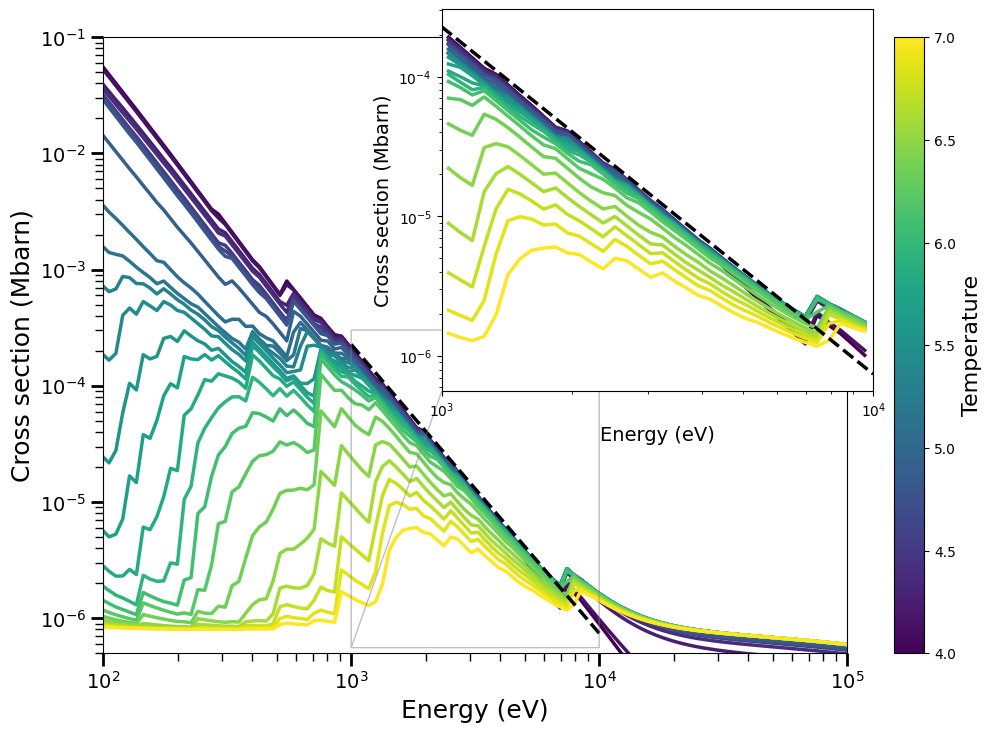

In [8]:
cmap = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=np.log10(Txsec[0]), vmax=np.log10(Txsec[-1]))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(Ntemp):
    ax.loglog(Earr, xsecs[i], '-', lw=2.5, color=scalarMap.to_rgba(np.log10(Txsec[i])))

eLower = 1.0
eUpper = 10.0
eMack = np.logspace(0, 1, 32)
xsecMack = (2.27E-22*(eMack**(-2.485)))*1E18

ax.loglog(eMack*1E3, xsecMack, 'k--', lw=2.5)
    
c = fig.colorbar(scalarMap, ax=ax)
c.set_label("Temperature", fontsize=16)
ax.set_xlabel("Energy (eV)", fontsize=18)
ax.set_ylabel("Cross section (Mbarn)", fontsize=18)
ax.set_xlim(1E2, 1E5)
ax.set_ylim(ymin=5E-7, ymax=1E-1)

ax2 = ax.inset_axes([0.455, 0.425, 0.58, 0.62])
inds = np.where((Earr >= 1E3) & (Earr <= 1E4))
iparam = 0
for i in range(len(Txsec)):
    ax2.loglog(Earr[inds], xsecs[i][inds], '-', lw=2.5, color=scalarMap.to_rgba(np.log10(Txsec[i])))
    #if(Txsec[i] > 10**3.5):
    #    ax2.loglog(eMack*1E3, funcfit(eMack*1E3, *params[iparam]), ':', lw=2.5, color=scalarMap.to_rgba(np.log10(Txsec[i])))
    #    iparam += 1
ax2.loglog(eMack*1E3, xsecMack, 'k--', lw=2.5)
ax2.set_xlim(1E3, 1E4)
ax2.set_xlabel("Energy (eV)", fontsize=14)
ax2.set_ylabel("Cross section (Mbarn)", fontsize=14)

ax.indicate_inset_zoom(ax2)
ax.tick_params(which='major', axis='both', labelsize=14, length=9, width=2)
ax.tick_params(which='minor', axis='both', length=6, width=1.)

fig.savefig("xsecs_temp.png", bbox_inches='tight')
plt.show()

In [9]:
#This is the file that needs to go into the runtime folder
#XrayCommonMain/XrayCommon_init reads this in
if writeFiles:
    f = open("xdr_xsecData.dat", "w")
    f.write("%d\t%d\n"%(Ntemp, Nres))

    for i in range(Ntemp):
        f.write("%.2f"%Txsec[i])
        if(i!=(Ntemp-1)):
            f.write("\t")
    f.write("\n")
    for i in range(Nres):
        f.write("%.2e"%(Earr[i]/1000.))
        if(i!=(Nres-1)):
            f.write("\t")
    f.write("\n")

    for i in range(Ntemp):
        for j in range(Nres):
            f.write("%.3e"%(xsecs[i][j]/1E18))
            if(j!=(Nres-1)):
                f.write("\t")
        f.write("\n")
    f.close()

In [10]:
Tselect = 10**5
ionFracDict = {}
for (i, el) in enumerate(elements):
    ionF = np.zeros(len(equilsDict[el]))
    for (j, ff) in enumerate(equilsDict[el]):
        finterp = si.interp1d(np.log10(temp), ff)
        ionF[j] = finterp(np.log10(Tselect))
        if(ionF[j] < 1E-6): ionF[j] = 0
    ionFracDict[el] = ionF

sigmaSpec = {}
comptSpec = {}

compDefault = KNcross(Earr)

for (Z, el) in zip(Zelements, elements):
    sigTot = np.zeros(Nres)
    ffracs = ionFracDict[el]
    ionState = range(Z+1,0,-1)
    Nfree = 0
    for iS in ionState:
        Nele = Z - iS + 1
        try:
            fraci = ffracs[iS-1]
        except IndexError:
            pass
        Nfree += fraci*float((iS-1))
        for n in range(7,-1,-1):
            for l in range(1,-1,-1):
                try:
                    fitparms = fitDict[(Z, Nele, n, l)]
                    sigTot += fraci*func(Earr, n, l, fitparms)
                except KeyError:
                    dum = 0
    sigmaSpec[el] = sigTot
    comptSpec[el] = float(Nfree)*compDefault

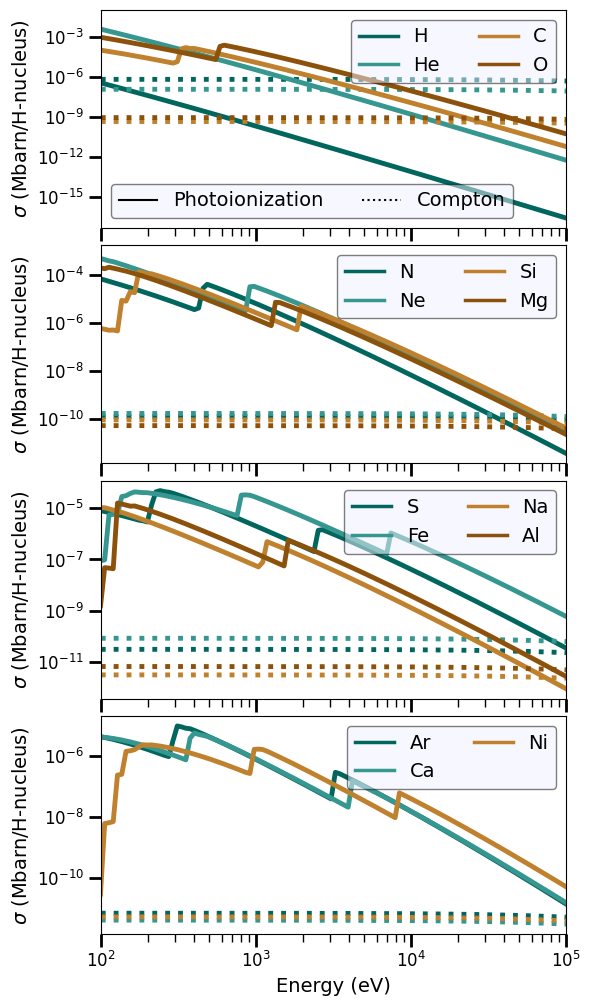

In [11]:
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
Nele = len(elements)

fig, axs = plt.subplots(nrows=4, ncols=1, sharex = True, gridspec_kw={'hspace':0.08}, figsize=(6,12))
custom_lines = []
eles = []
iplot = 0

lines2 = [Line2D([0], [0], color='k', linestyle='-'),Line2D([0], [0], color='k', linestyle=':')]
label2 = ['Photoionization', 'Compton']

colorsEle = ['#01665e', '#35978f', '#bf812d', '#8c510a']
linestyles = ['-', '--', '-.', ':']

for (i,el) in enumerate(elements):
    k = int(i/4)
    icol = 1 #int(k%2)
    irow = int(k/4)
    
    eles.append(el.capitalize())
    custom_lines.append(Line2D([0],[0], color=colorsEle[i%4], lw=2.5)) #color=plt.cm.Set2(float(i%8)/8.)))
    splot = np.zeros(Nres)
    splot[:] = sigmaSpec[el][:]
    splot[np.where(splot == 0)] = np.nan
    axs[k].loglog(Earr, abund_dict[el]*splot, '-', linewidth=3.5, color=colorsEle[i%4]) #plt.cm.Set2(float(i%8)/8.))
    axs[k].loglog(Earr, abund_dict[el]*comptSpec[el], ':', linewidth=3.5, color=colorsEle[i%4]) #color=plt.cm.Set2(float(i%8)/8.))
    iplot += 1
    if (iplot%4 == 0) or (iplot == 15):
        if(k == 0):
            axs[k].legend(custom_lines, eles, loc=1, facecolor='#f0f0ff', ncol=2, edgecolor='k', framealpha=0.5, fontsize=14)
            l2 = Legend(axs[k], lines2, label2, loc=3, facecolor='#f0f0ff', ncol=2, edgecolor='k', framealpha=0.5, fontsize=14)
            axs[k].add_artist(l2)
        else:
            axs[k].legend(custom_lines, eles, loc=1, facecolor='#f0f0ff', ncol=2, edgecolor='k', framealpha=0.5, fontsize=14)
        eles = []
        custom_lines = []


for ax in axs:
    ax.set_xlim(1E2, 1E5)
    ax.set_ylabel("$\sigma$ (Mbarn/H-nucleus)", fontsize=14)
    ax.tick_params(which='major', axis='both', labelsize=12, length=9, width=2)
    ax.tick_params(which='minor', axis='both', length=6, width=1.)
    
axs[-1].set_xlabel("Energy (eV)", fontsize=14)
fig.savefig("Figures/cross_section_species.pdf", bbox_inches='tight')
plt.show()

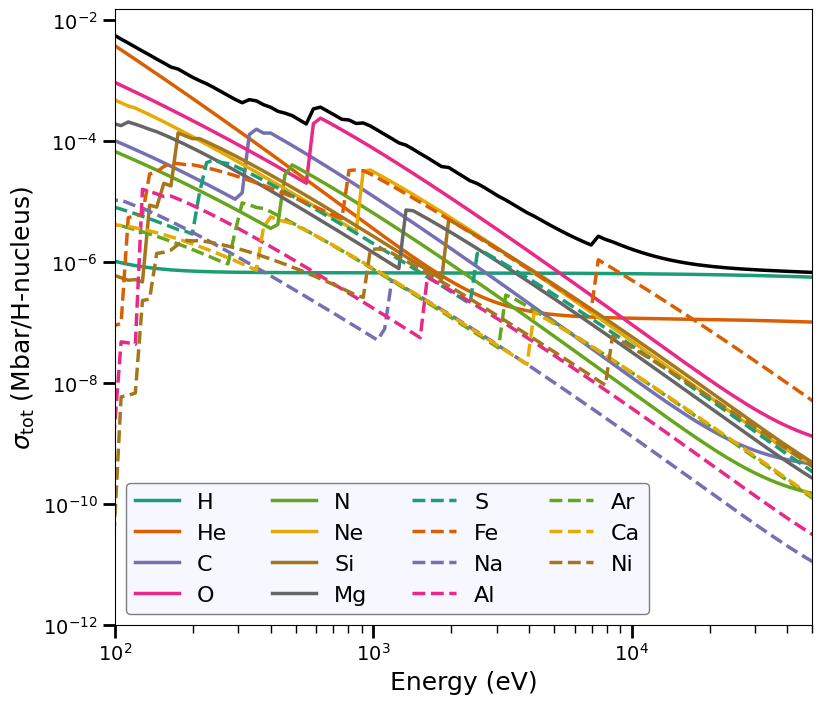

In [12]:
sigma_tot = np.zeros(Nres)
for (i,el) in enumerate(elements):
    sigma_tot += abund_dict[el]*(sigmaSpec[el])
    sigma_tot += abund_dict[el]*(comptSpec[el])
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)

lws = ['-', '--']

for (i,el) in enumerate(elements):
    eles.append(el.capitalize())
    custom_lines.append(Line2D([0],[0], linestyle=lws[int(i/8)], color=plt.cm.Dark2(float(i%8)/8.), lw=2.5))
    splot = abund_dict[el]*(sigmaSpec[el]+comptSpec[el])
    ax.loglog(Earr, splot, linewidth=2.5, linestyle=lws[int(i/8)] ,color=plt.cm.Dark2(float(i%8)/8.))

ax.loglog(Earr, sigma_tot, 'k-', lw=2.5)    
    
ax.legend(custom_lines, eles, loc=3, ncol=4, facecolor='#f0f0ff', edgecolor='k', framealpha=0.5, fontsize=16)
eles = []
custom_lines = []

ax.set_xlim(1E2, 5E4)
ax.set_xlabel("Energy (eV)", fontsize=18)
ax.set_ylabel(r"$\sigma_{\rm tot}$ (Mbar/H-nucleus)", fontsize=18)
ax.tick_params(which='major', axis='both', labelsize=14, length=9, width=2)
ax.tick_params(which='minor', axis='both', length=6, width=1.)
fig.savefig("Figures/cross_sections_allSpec.pdf")
ax.set_ylim(1E-12, 1.5E-2)
plt.show()

if writeFiles:
    f = open("xsec_select.dat", "w+")
    for i in range(Nres):
        f.write("%.2e\t%.2e\n"%(Earr[i], sigma_tot[i]/1E18))
    f.write("\n")
    f.close()